# Step 0

* Read the h5 file containing the scan data.
* Make sure the scan went as expected.
* Process the camera images.
* Create a new h5 file with separate scalar (0D), waveform (1D), and image (2D) data sets. The new file name is "prepoc-" + the original file name.

In [1]:
import sys
import os
from os.path import join
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import skimage
from tqdm import trange
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['grid'] = False

## Load data

In [3]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29/'
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [4]:
filename = '220429190854-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, filename + '.h5'), 'r')
print(list(file))

['config', 'log', 'scandata']


In [5]:
config = file['config']

print(f"'config', {type(config)}")
for key in config:
    print(f"  '{key}', {type(config[key])}")
    for item in config[key].dtype.fields.items():
        print('    ', item)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
     ('timestamp', (dtype('<f8'), 0))
     ('user', (dtype('S256'), 8))
     ('host', (dtype('S256'), 264))
     ('cmd_line', (dtype('S256'), 520))
     ('work_dir', (dtype('S256'), 776))
  'metadata', <class 'h5py._hl.dataset.Dataset'>
     ('timestamp', (dtype('<f8'), 0))
     ('Test_LLRF:FCM_RFQ1:CtlAmpSet', (dtype('<f8'), 8))
     ('RFTF_TM:Gate_BeamOn:RR', (dtype('<f8'), 16))
     ('BTF_MEBT_Mag:PS_QH01:I_Set', (dtype('<f8'), 24))
     ('BTF_MEBT_Mag:PS_QV02:I_Set', (dtype('<f8'), 32))
     ('BTF_MEBT_Mag:PS_QH03:I_Set', (dtype('<f8'), 40))
     ('BTF_MEBT_Mag:PS_QV04:I_Set', (dtype('<f8'), 48))
     ('BTF_MEBT_Mag:PS_QH05:I_Set', (dtype('<f8'), 56))
     ('BTF_MEBT_Mag:PS_QV06:I_Set', (dtype('<f8'), 64))
     ('BTF_MEBT_Mag:PS_QV07:I_Set', (dtype('<f8'), 72))
     ('BTF_MEBT_Mag:PS_QH08:I_Set', (dtype('<f8'), 80))
     ('BTF_MEBT_Mag:PS_QV09:I_Set', (dtype('<f8'), 88))
     ('BTF_MEBT_Mag

In [6]:
log = file['log']

print(f"'log', {type(log)}")
for item in log.dtype.fields.items():
    print('  ', item)
    
print('\nErrors and warnings:')
for i in range(log.size):
    if not(log[i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:
04/29/2022, 19:54:49 b'Step/sweep 253 invalid due to lack of data, will re-try in 1 seconds.'
04/29/2022, 19:55:06 b'Step/sweep 253 invalid due to lack of data, will re-try in 2 seconds.'
04/29/2022, 19:55:24 b'Step/sweep 253 invalid due to lack of data, will re-try in 4 seconds.'
04/29/2022, 19:55:44 b'Step/sweep 253 invalid due to lack of data, will re-try in 8 seconds.'
04/29/2022, 19:56:07 b'Step/sweep 253 invalid due to lack of data, will re-try in 16 seconds.'
04/29/2022, 19:56:39 b'Step/sweep 253 invalid due to lack of data, will re-try in 32 seconds.'
04/29/2022, 19:57:27 b'Step/sweep 253 invalid due to lack of data, will re-try in 64 seconds.'
04/29/2022, 19:58:47 b'Step/sweep 253 invalid due to lack of data, will re-try in 128 seconds.'
04/29/2022, 20:01:11 b'Step/sweep 253 inv

In [7]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('cam34_Image', (dtype(('<i4', (313344,))), 16))
   ('cam34_ProfileY', (dtype(('<f4', (512,))), 1253392))
   ('cam34_ProfileX', (dtype(('<f4', (612,))), 1255440))
   ('cam34_Saturation', (dtype('<f8'), 1257888))
   ('cam34_Integral', (dtype('<f8'), 1257896))
   ('bcm04', (dtype('<f8'), 1257904))
   ('y_PositionSync', (dtype('<f8'), 1257912))
   ('xp_PositionSync', (dtype('<f8'), 1257920))
   ('x_PositionSync', (dtype('<f8'), 1257928))


In [8]:
acts = ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']

## Scan overview 

### Data collection frequency

In [9]:
duration = data[-1, 'timestamp'] - data[0, 'timestamp']
iteration_duration = duration / data[-1, 'iteration']
points_per_iteration = len(data) / data[-1, 'iteration']
print(f'{len(data)} points recorded over {duration:.1f} seconds ({(duration / 3600.0):.1f} hours)')
print(f"Number of iterations: {data[-1, 'iteration']}")
print(f'Effective rep rate: {(len(data) / duration):.2f} Hz')
print(f'Time per iteration: {iteration_duration:.2f} seconds')
print(f'Points per iteration: {points_per_iteration:.2f} seconds')

46146 points recorded over 15885.6 seconds (4.4 hours)
Number of iterations: 1089
Effective rep rate: 2.90 Hz
Time per iteration: 14.59 seconds
Points per iteration: 42.37 seconds


Look for long pauses during data collection.

reprate = 5.00 Hz
Pauses longer than 30 seconds:
[1191.90364909 1802.96420908 1184.74736118]
Most pauses are 2.40 seconds


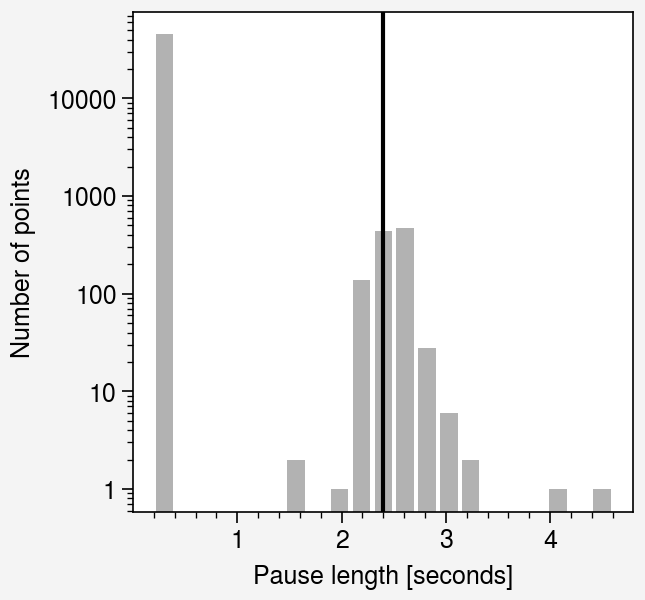

In [10]:
dt = np.diff(data[:, 'timestamp'])
rep_rate = 1.0 / np.median(dt)
print(f'reprate = {rep_rate:.2f} Hz')

print('Pauses longer than 30 seconds:')
long_pause = 30.0
print(dt[dt > long_pause])
dt[dt > long_pause] = 0.2

hist, bins = np.histogram(dt, bins=21)
idx_bins = np.digitize(dt, bins)
idx_pause, = np.where(idx_bins > 1)
median_pause = np.median(dt[idx_pause])
print(f'Most pauses are {median_pause:.2f} seconds')

fig, ax = pplt.subplots()
ax.bar(0.5 * (bins[1:] + bins[:-1]), hist, color='black', alpha=0.3)
ax.axvline(median_pause, color='black')
ax.format(xlabel='Pause length [seconds]', ylabel='Number of points', yscale='log')
plt.show()

### Measured beam current

In [11]:
bcm = 'bcm04'
bcm_limit = 25.0  # [mA]

idx = np.arange(len(data))
idx_mask, = np.where(data[bcm] > -bcm_limit)
idx_valid, = np.where(~np.isin(idx, idx_mask))

print(f'Average BCM current (before masking) = {np.mean(data[bcm]):.3f} +- {np.std(data[bcm]):.3f} [mA]')
for i in idx_mask:
    print(f'Point {i} masked due to {bcm} current < {bcm_limit:.3f} [mA]')
print(f'Average BCM current (after masking) = {np.mean(data[bcm][idx_valid]):.3f} +- {np.std(data[bcm][idx_valid]):.3f} [mA]')

Average BCM current (before masking) = -29.828 +- 0.223 [mA]
Point 41812 masked due to bcm04 current < 25.000 [mA]
Point 41813 masked due to bcm04 current < 25.000 [mA]
Average BCM current (after masking) = -29.829 +- 0.103 [mA]


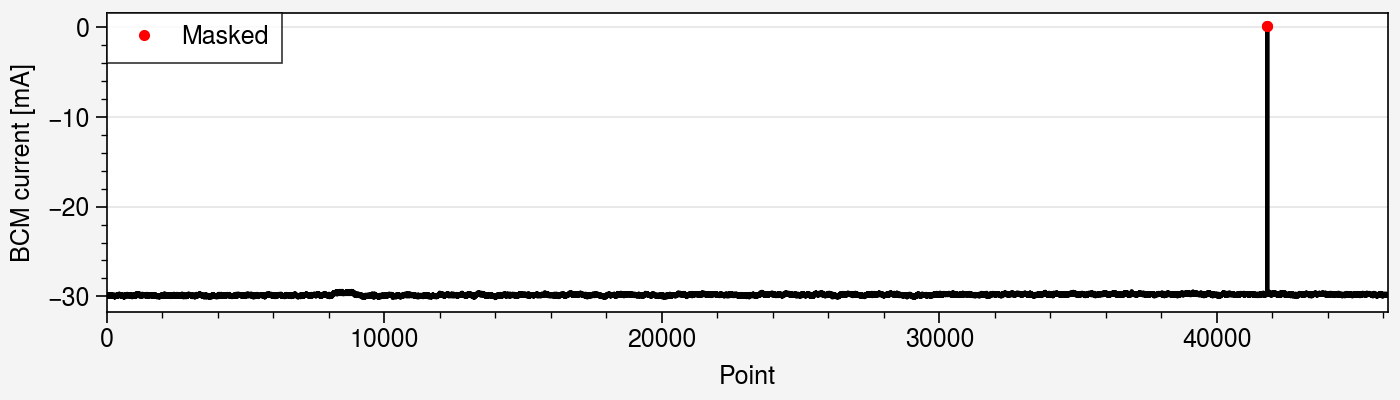

In [12]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(data[bcm][idx], color='black')
ax.plot(idx_mask, data[bcm][idx_mask], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
plt.show()

### Slit positions 

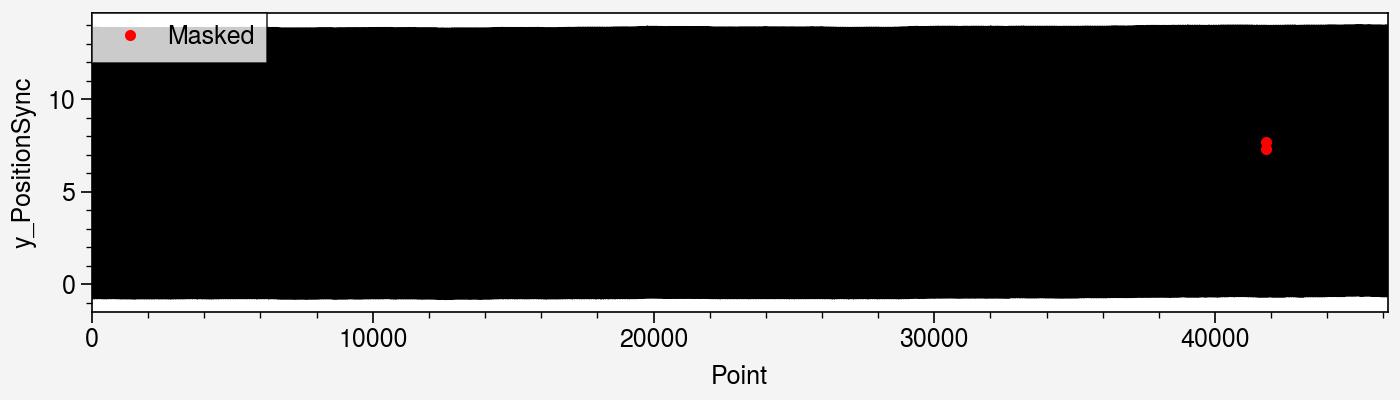

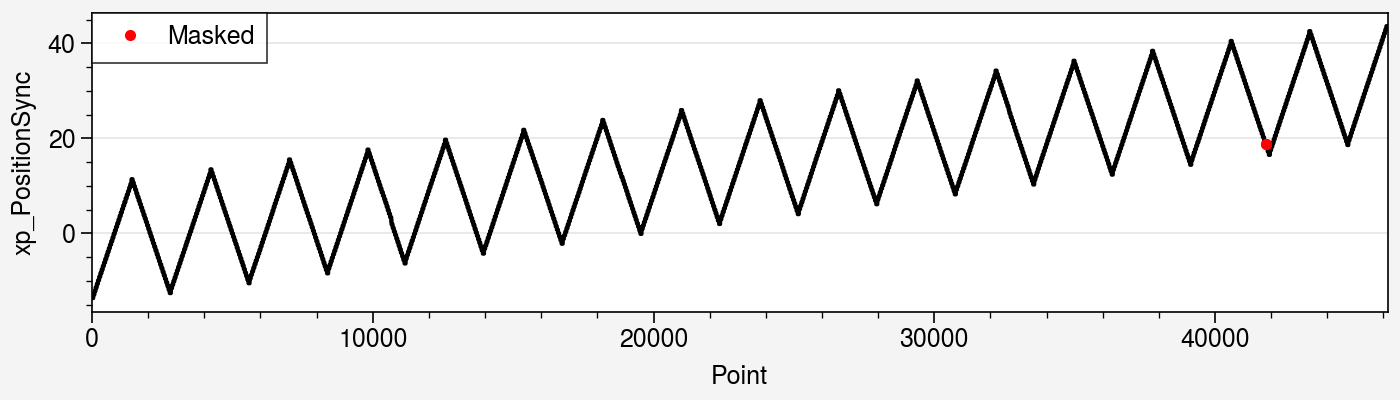

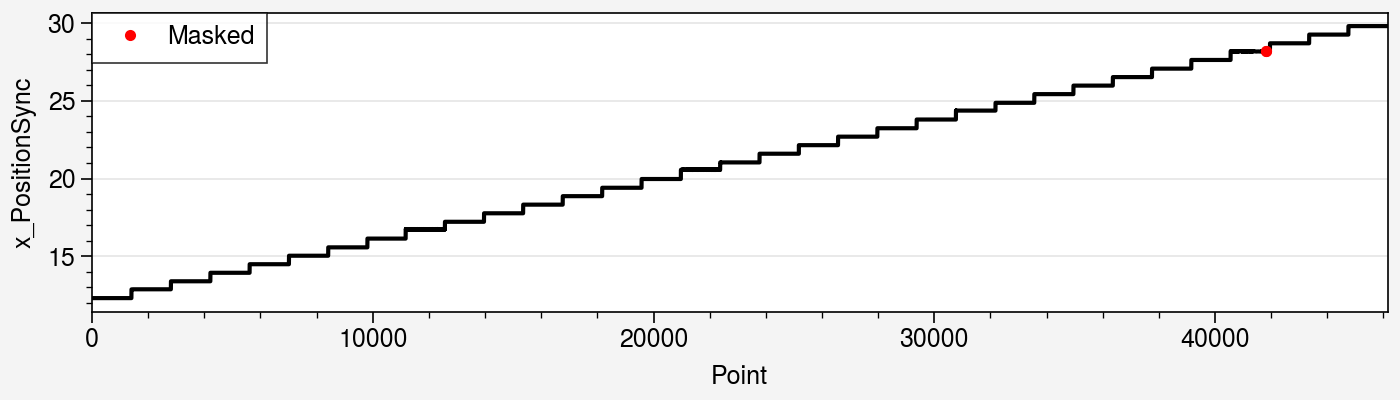

In [13]:
for act in acts:
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(idx, data[idx, act], color='black')
    ax.plot(idx_mask, data[idx_mask, act], color='red', lw=0, marker='.', label='Masked')
    ax.format(xlabel='Point', ylabel=act, ygrid=True)
    ax.legend(loc='upper left')
    plt.show()

## Process images 

In [14]:
cam = 'cam34'
cam_settings = ip.camera_settings(cam)
ny = cam_settings.ny
nx = cam_settings.nx
print(f'Raw image shape: ({ny}, {nx})')
print(f"file['scandata'].nbytes = {data.nbytes:.2e}")

Raw image shape: (512, 612)
file['scandata'].nbytes = 5.80e+10


Use the image with the peak camera integral for testing.

Peak signal at i = 31474


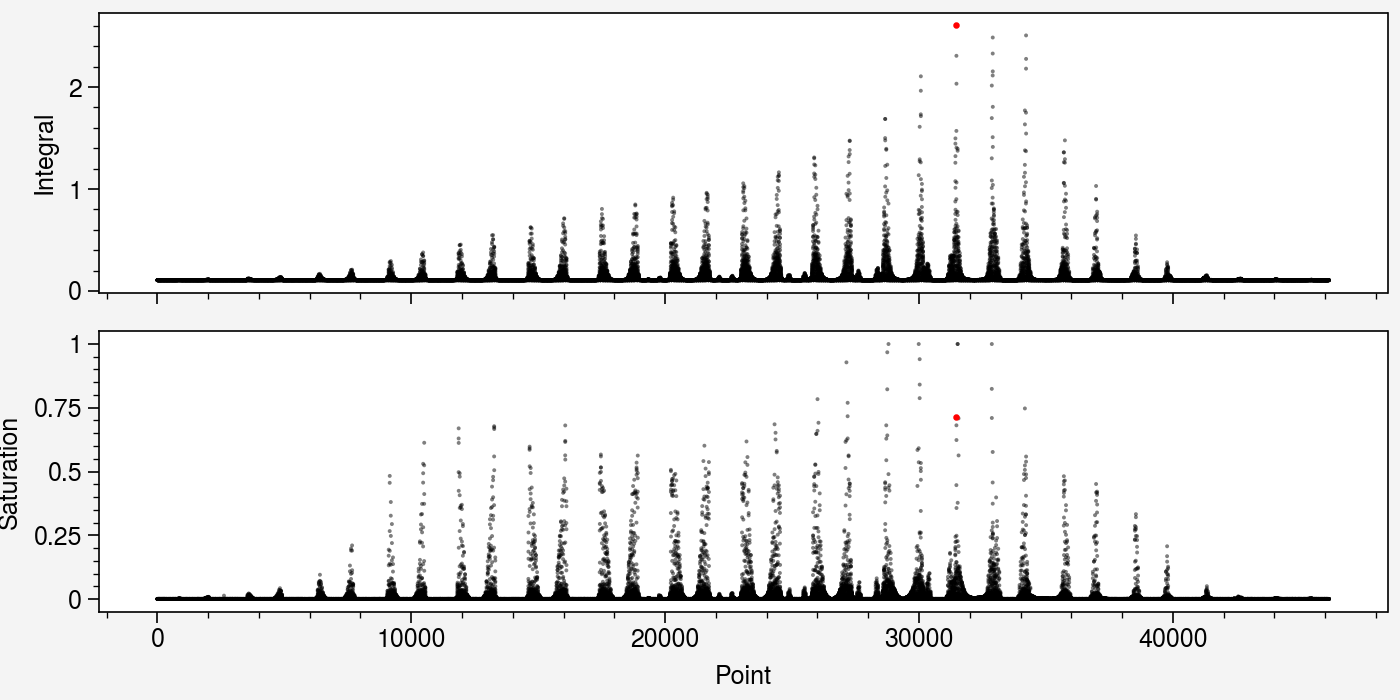

In [15]:
ipeak = np.argmax(data[cam + '_Integral'])
print(f'Peak signal at i = {ipeak}')

fig, axes = pplt.subplots(nrows=2, figsize=(7, 3.5), spany=False)
for ax, param in zip(axes, ['Integral', 'Saturation']):
    name = cam + '_' + param
    ax.scatter(idx, data[name], color='black', alpha=0.5, ec='None', s=2)
    ax.scatter(ipeak, data[ipeak, name], color='red', s=3)
    ax.format(ylabel=param, xlabel='Point')
plt.show()

In [16]:
def get_image(i, shape=None):
    if shape is None:
        shape = (cam_settings.ny, cam_settings.nx)
    return data[i, cam + '_Image'].reshape(shape)

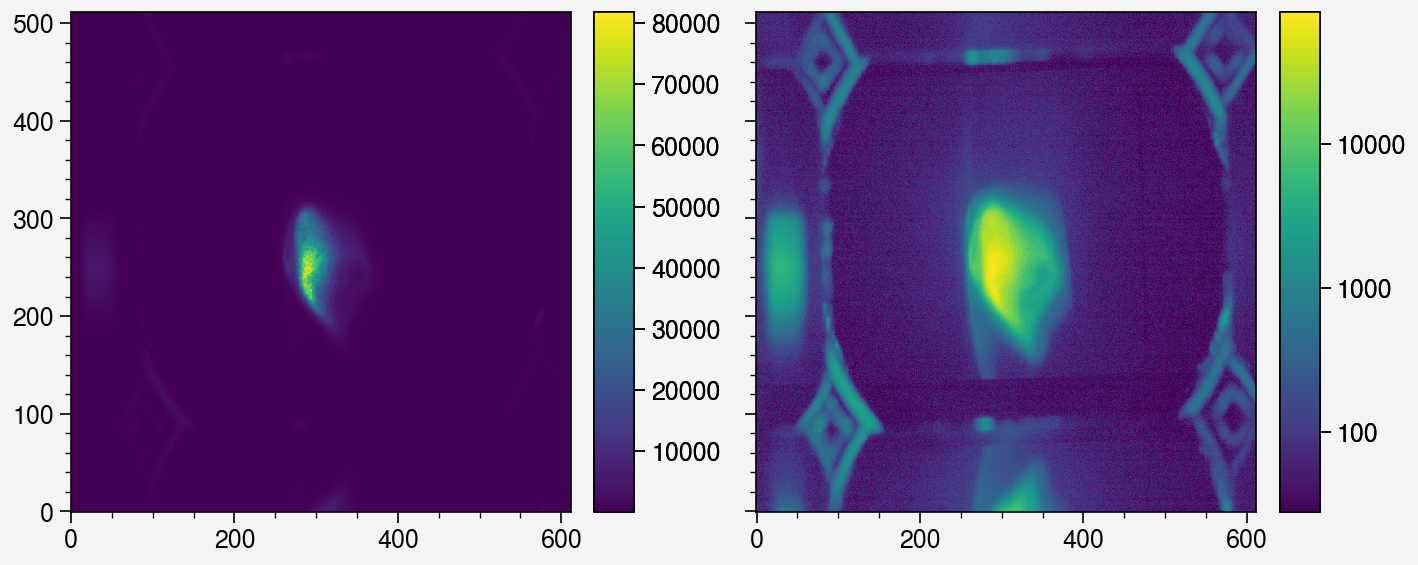

In [17]:
im = get_image(ipeak)

fig, axes = pplt.subplots(ncols=2)
kws = dict(colorbar=True)
axes[0].pcolor(im, **kws)
axes[1].pcolor(im, norm='log', **kws)
plt.show()

In [18]:
def plot_compare_images(im1, im2, **plot_kws):
    """Plot images side by side, and a second row in log scale."""
    fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
    for col, _im in enumerate([im1, im2]):
        for row, log in enumerate([False, True]):
            norm = None
            if log:
                _im = np.ma.masked_less_equal(_im, 0)
                norm = 'log'
            axes[row, col].pcolormesh(_im, norm=norm, **plot_kws)
    axes.format(leftlabels=['Normal scale', 'Log scale'])
    return axes

### Downscale 

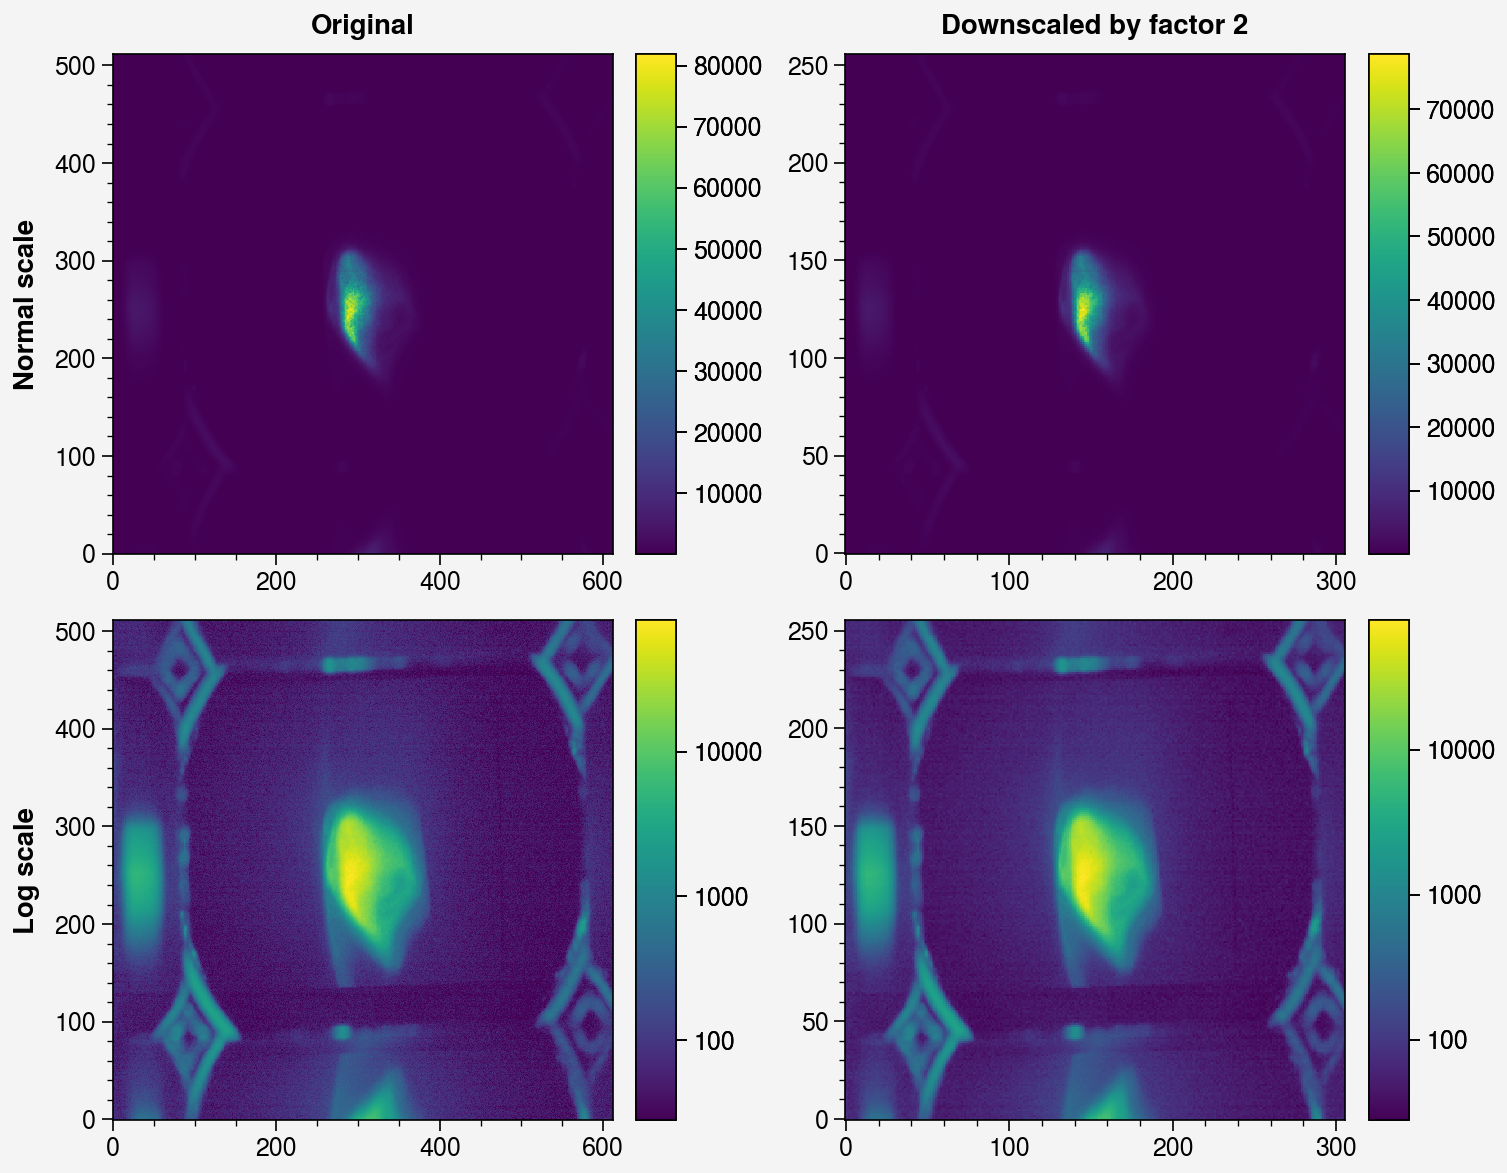

In [19]:
downscale_factor = 2
np.savetxt('processed_image_downscale_factor.txt', [downscale_factor], fmt='%i')

if downscale_factor > 1:
    im1 = skimage.transform.downscale_local_mean(
        im, 
        (downscale_factor, downscale_factor)
    )
else:
    im1 = im
axes = plot_compare_images(im, im1, colorbar=True)
axes.format(toplabels=['Original', f'Downscaled by factor {downscale_factor}'])

### Crop

If the camera is zoomed out, it is necessary to crop the image to get rid of reflections.

In [20]:
im = im1.copy()

In [21]:
x1, x2 = (np.array([135, -90]) / downscale_factor).astype(int)
y1, y2 = (np.array([135, -85]) / downscale_factor).astype(int)
edges = dict(x1=x1, x2=x2, y1=y1, y2=y2)

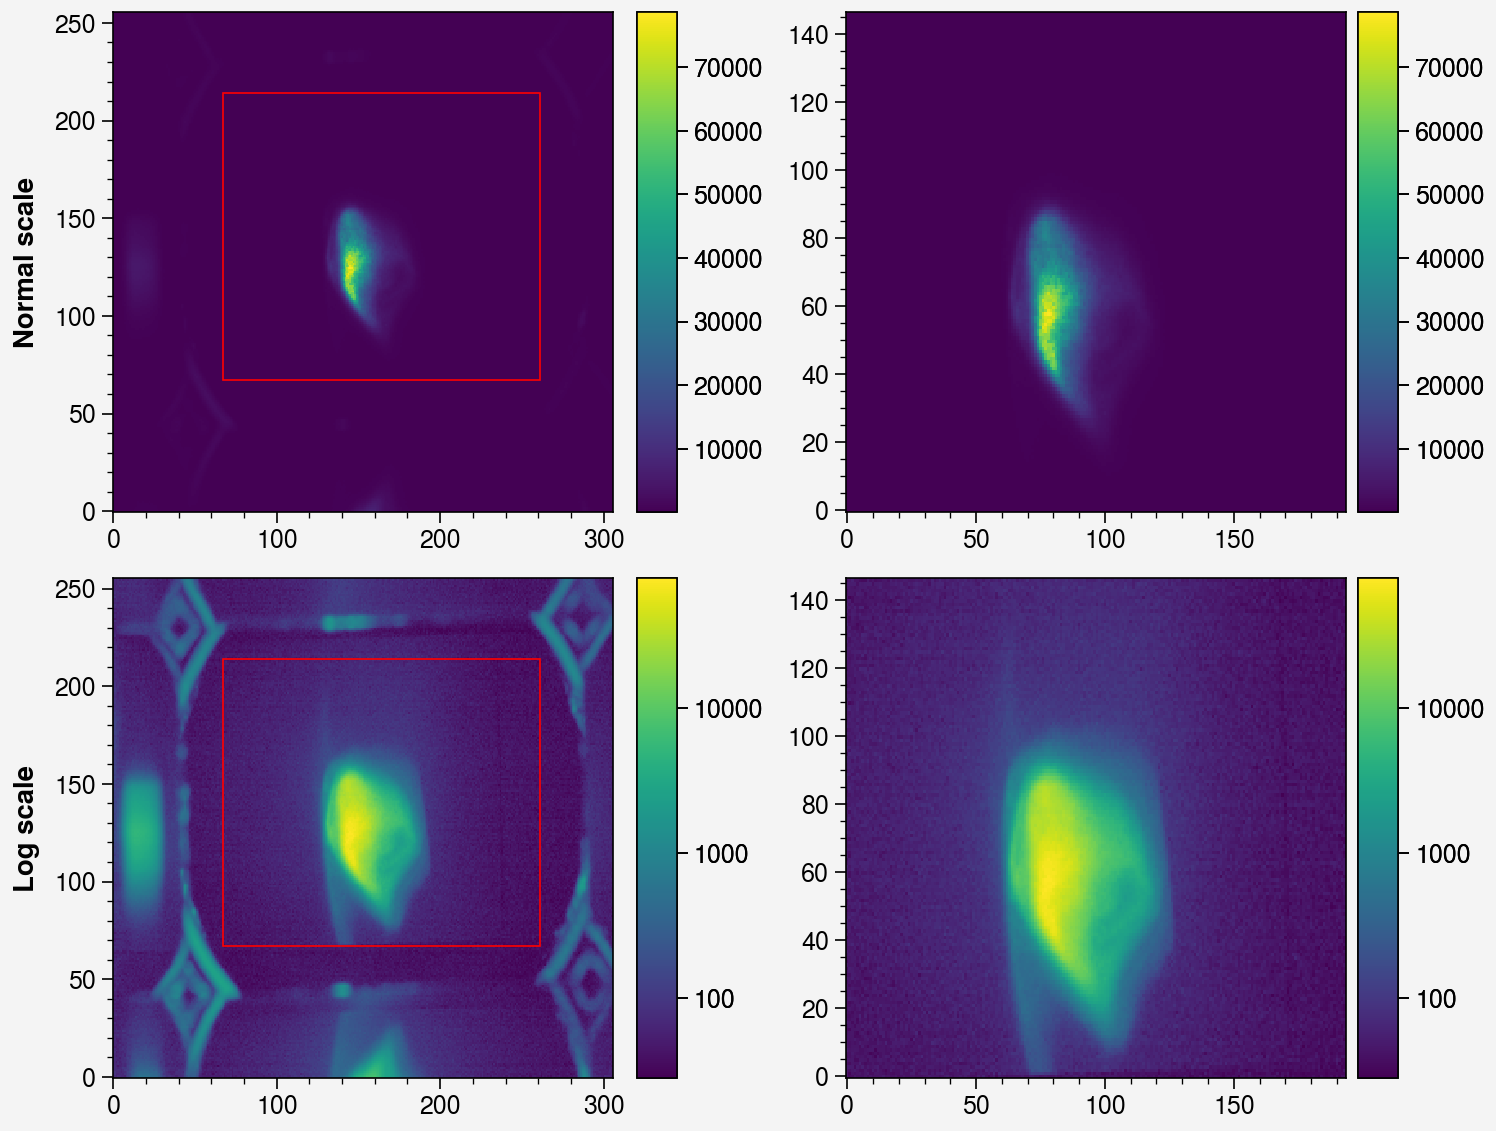

In [22]:
im1 = ip.crop(im, **edges)

axes = plot_compare_images(im, im1, colorbar=True)
for ax in axes[:, 0]:
    ax.add_patch(patches.Rectangle((x1, y1), im1.shape[1], im1.shape[0], fill=False, ec='red'))
plt.show()

Get a sense of how cropping affects every image.

In [23]:
px = skimage.transform.downscale_local_mean(data[cam + '_ProfileX'], (1, downscale_factor))
py = skimage.transform.downscale_local_mean(data[cam + '_ProfileY'], (1, downscale_factor))

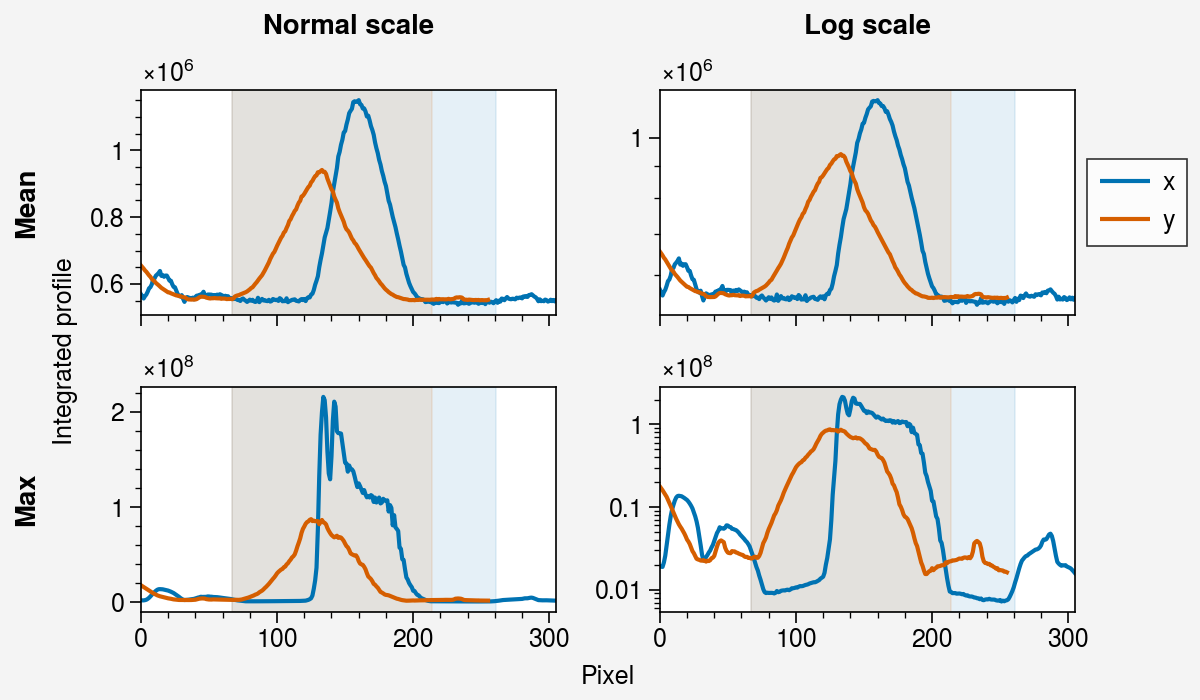

In [24]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(6, 3.5), sharey=1)
for j in range(2):
    for ax, func in zip(axes[:, j], [np.mean, np.max]):
        for p, label in zip([px, py], ['x', 'y']):
            f = func(p, axis=0)
            ax.plot(np.arange(p.shape[1]), func(p, axis=0), label=label)
axes[0, 1].legend(ncols=1, loc='r')

colors = pplt.Cycle('colorblind').by_key()['color']
for _x1, _x2, _xmax, c in zip([x1, y1], [x2, y2], [px.shape[1], py.shape[1]], colors):
    if _x2 < 0:
        _x2 += _xmax
    for ax in axes:
        ax.axvspan(_x1, _x2, color=c, alpha=0.1)
    
axes[:, 1].format(yscale='log')
axes.format(leftlabels=['Mean', 'Max'], toplabels=['Normal scale', 'Log scale'],
            xlabel='Pixel', ylabel='Integrated profile')
plt.show()

### Threshold

In [25]:
im = im1.copy()

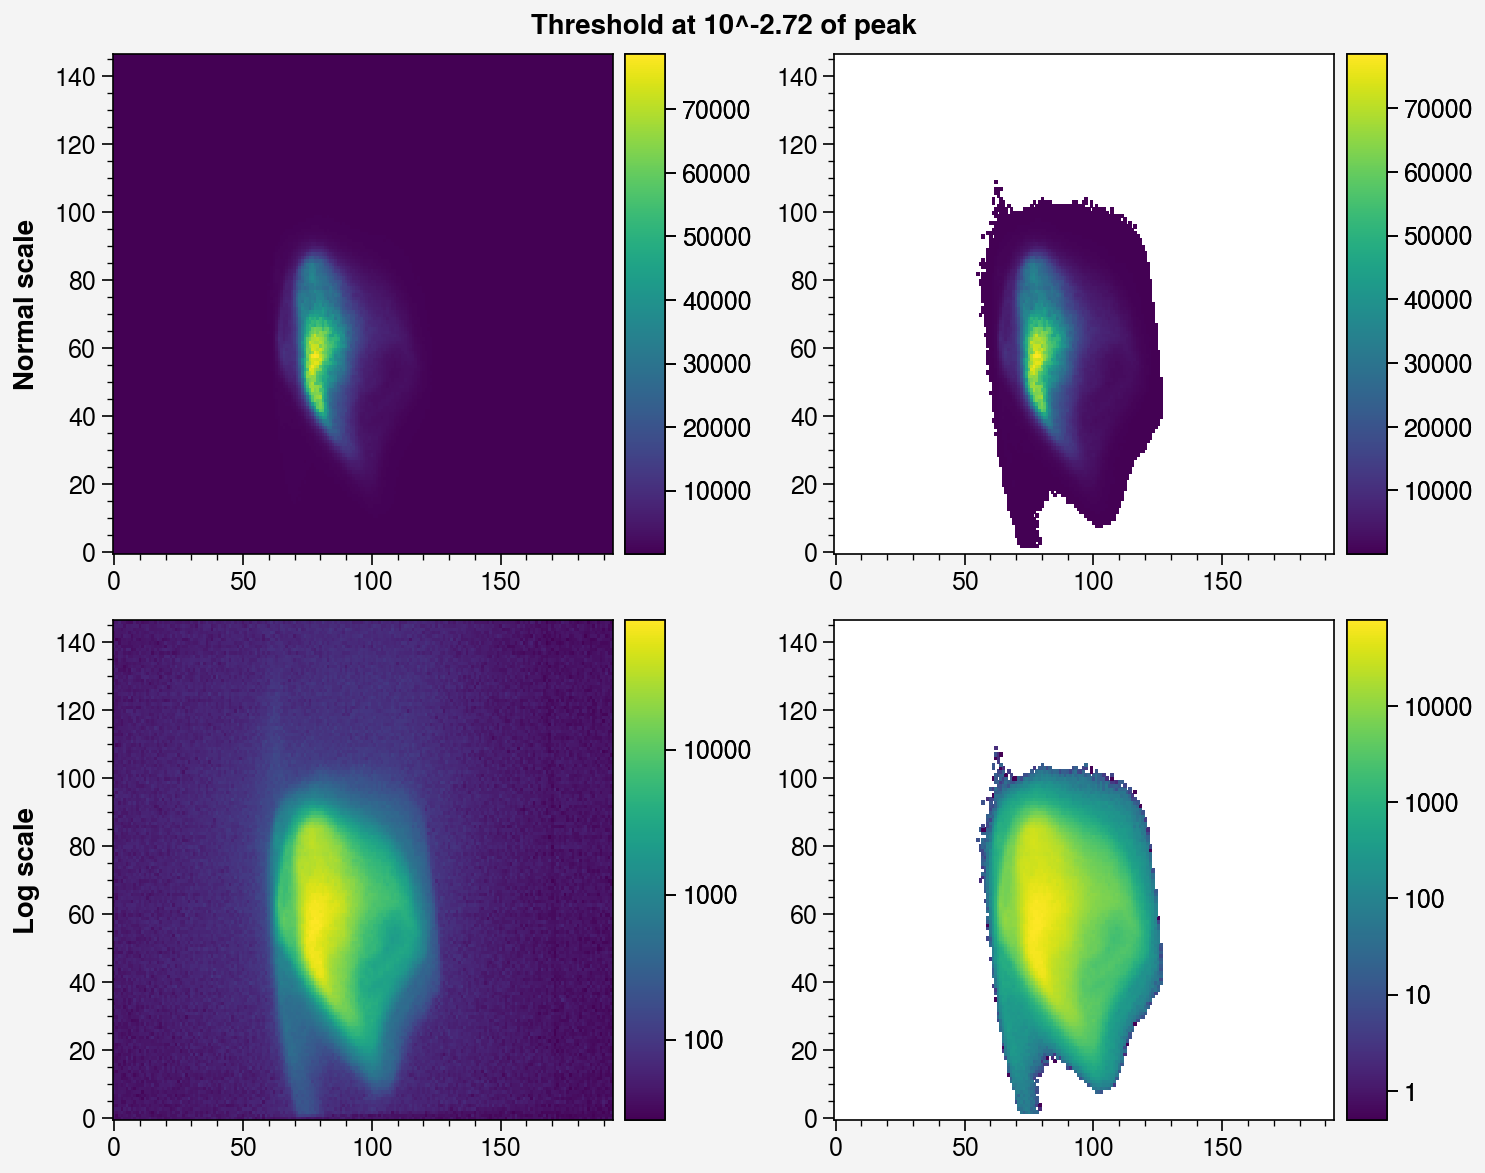

In [26]:
thresh = 150
thresh_frac_peak = thresh / np.max(im)

im1 = im.copy()
im1 -= thresh
im1[im1 < 0] = 0

axes = plot_compare_images(im, np.ma.masked_less_equal(im1, 0), colorbar=True)
axes.format(suptitle=f'Threshold at 10^{np.log10(thresh_frac_peak):.2f} of peak')

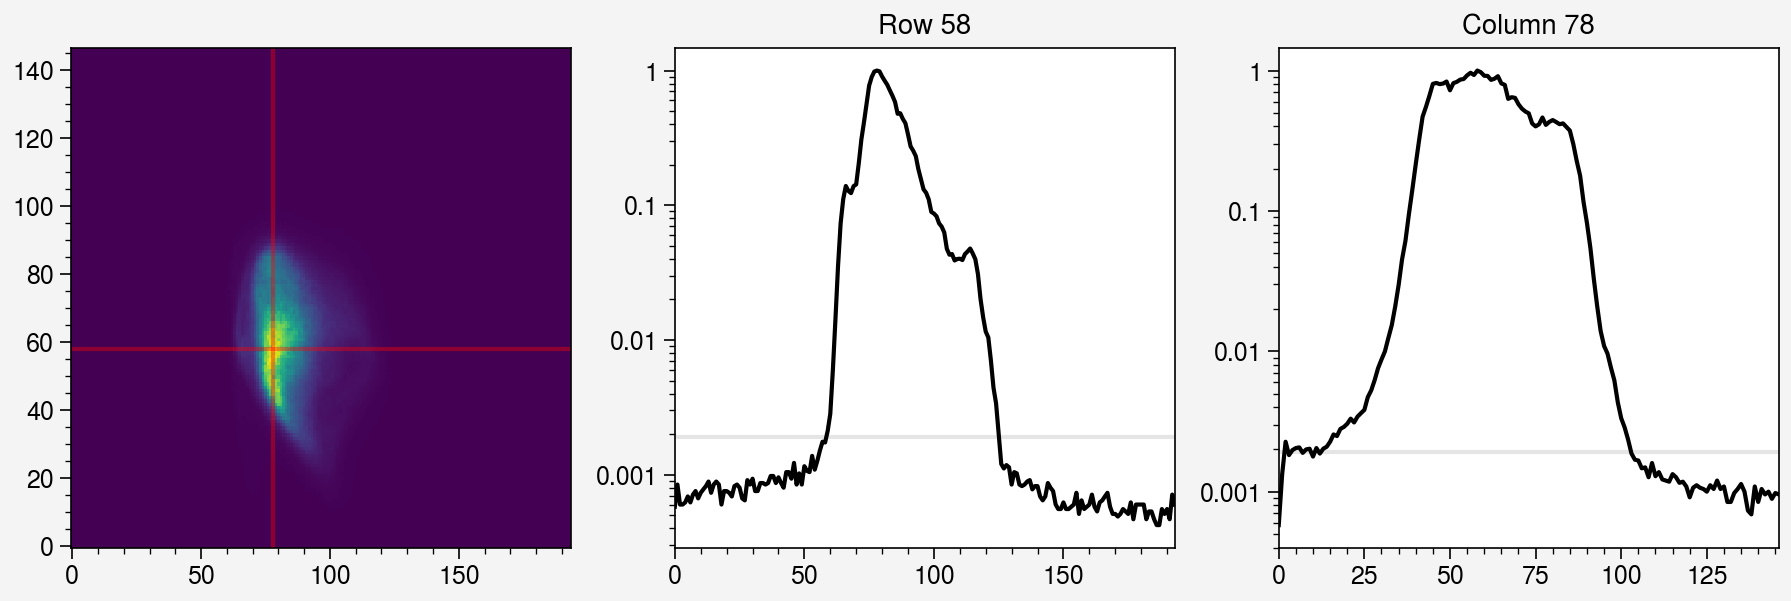

In [27]:
i, j = np.unravel_index(np.argmax(im), im.shape)
fig, axes = pplt.subplots(ncols=3, sharey=False)
axes[0].pcolormesh(im)
kws = dict(color='red', alpha=0.4)
axes[0].axhline(i, **kws)
axes[0].axvline(j, **kws)
axes[1].set_title(f'Row {i}')
axes[2].set_title(f'Column {j}')
kws = dict(color='black', lw=None)
axes[1].plot(np.arange(im.shape[1]), im[i, :] / np.max(im[i, :]), **kws)
axes[2].plot(np.arange(im.shape[0]), im[:, j] / np.max(im[:, j]), **kws)
axes[1].axhline(thresh / np.max(im[i, :]), color='black', alpha=0.1)
axes[2].axhline(thresh / np.max(im[:, j]), color='black', alpha=0.1)
axes[1:].format(yscale='log')
plt.show()

In [28]:
im = im1.copy()

In [29]:
ny, nx = im.shape
np.savetxt('processed_image_shape.txt', [ny, nx], fmt='%i')
print('Processed image shape =', ny, nx)

Processed image shape = 147 194


Now we process all the images.

In [30]:
images = []
for index in trange(len(data)):
    im = get_image(index)
    im = skimage.transform.downscale_local_mean(
        im, 
        (downscale_factor, downscale_factor),
    )
    im = ip.crop(im, **edges)
    im -= thresh
    im[im < 0] = 0
    images.append(im)

100%|██████████| 46146/46146 [04:22<00:00, 175.73it/s]


## Write new h5 file

Create a new h5 file with three data sets: scalar (0d), waveform (1d), and image (2d). First, collect the appropriate dtypes.

In [31]:
attrs = data.dtype.names
sc_dtype, sc_attrs = [], list(attrs)
print(sc_attrs)
wf_dtype, wf_attrs = [], []
im_dtype, im_attrs = [], []
print('Moving the following columns:')
for i in reversed(range(len(attrs))):
    attr = attrs[i]
    if '_Image' in attr:
        sc_attrs.pop(i)
        im_attrs.append(attr)
        im_dtype.append((attr, data.dtype[attr]))
        print(attr)
    elif 'Profile' in attr:
        sc_attrs.pop(i)
        wf_attrs.append(attr)
        wf_dtype.append((attr, data.dtype[attr]))
        print(attr)
    else:
        sc_dtype.append((attr, data.dtype[attr]))
        
sc_dtype = np.dtype(sc_dtype)
wf_dtype = np.dtype(wf_dtype)
im_dtype = np.dtype(im_dtype)

# Override the image dtype. The original images had dtype '<i4', but they
# became floats if they were downsized.
im_dtype = np.dtype([(cam + '_Image', str(images[0].dtype), (images[0].size,))])

print('\nscalars:')
print(sc_dtype)
print('\nwaveforms:')
print(wf_dtype)
print('\nimage:')
print(im_dtype)

['timestamp', 'iteration', 'cam34_Image', 'cam34_ProfileY', 'cam34_ProfileX', 'cam34_Saturation', 'cam34_Integral', 'bcm04', 'y_PositionSync', 'xp_PositionSync', 'x_PositionSync']
Moving the following columns:
cam34_ProfileX
cam34_ProfileY
cam34_Image

scalars:
[('x_PositionSync', '<f8'), ('xp_PositionSync', '<f8'), ('y_PositionSync', '<f8'), ('bcm04', '<f8'), ('cam34_Integral', '<f8'), ('cam34_Saturation', '<f8'), ('iteration', '<i8'), ('timestamp', '<f8')]

waveforms:
[('cam34_ProfileX', '<f4', (612,)), ('cam34_ProfileY', '<f4', (512,))]

image:
[('cam34_Image', '<f8', (28518,))]


Skip points with slow BCM current (see above).

In [32]:
n_valid = len(idx_valid)
for i in idx_mask:
    print(f'Ignoring point {i} due to {bcm} current < {bcm_limit} [mA]')
print(f'Number of valid points: {n_valid}')

Ignoring point 41812 due to bcm04 current < 25.0 [mA]
Ignoring point 41813 due to bcm04 current < 25.0 [mA]
Number of valid points: 46144


In [33]:
writer = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'w')
data_sc = writer.create_dataset('scalardata', (n_valid,), dtype=sc_dtype)
data_wf = writer.create_dataset('wfdata', (n_valid,), dtype=wf_dtype)
data_im = writer.create_dataset('imagedata', (n_valid,), dtype=im_dtype)
for i in trange(n_valid):
    for attr in sc_attrs:
        data_sc[i, attr] = data[i, attr]
    for attr in wf_attrs:
        data_wf[i, attr] = data[i, attr]
    for attr in im_attrs:
        # data_im[i, attr] = data[i, attr]
        data_im[i, attr] = images[i].ravel()
writer.close()

100%|██████████| 46144/46144 [05:16<00:00, 145.90it/s]
